In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects  # Import path effects for text outline
import pandas as pd
from utils import *

In [3]:
# avg_power 378.8556695697469 std_power 3.631425271401822

# avg_power 93.54626298542978 std_power 2.497080950805588
# avg_power 93.95008267753535 std_power 2.7211928636453404

BASE_MEAN_mW = 378.8556695697469
BASE_STD_mW = 3.631425271401822

SMALL_MEAN_mW = 93.54626298542978
SMALL_STD_mW = 2.497080950805588

BART_MEAN_mW = 93.95008267753535
BART_STD_mW = 2.7211928636453404

### RUN PLOTTING

In [4]:
# Load task records from the CSV file
file_path_no_dare_no_session = '../results/10_users_3_tasks/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_False_v2.csv'  # Ensure this matches your saved file name
file_path_no_dare_yes_session = '../results/10_users_3_tasks/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'  # Ensure this matches your saved file name
file_path_yes_dare_no_session = '../results/10_users_3_tasks/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_True_session_False_v2.csv'  # Ensure this matches your saved file name

# file_path = file_path_no_dare_no_session
# file_path = file_path_no_dare_yes_session
file_path = file_path_yes_dare_no_session

task_records = load_task_records(file_path)

if task_records is None:
    print("Failed to load task records. Exiting.")

In [5]:
calculate_total_waiting_time(task_records)

(12.82138501042905, 12.09900270959136, 294.89185523986816)

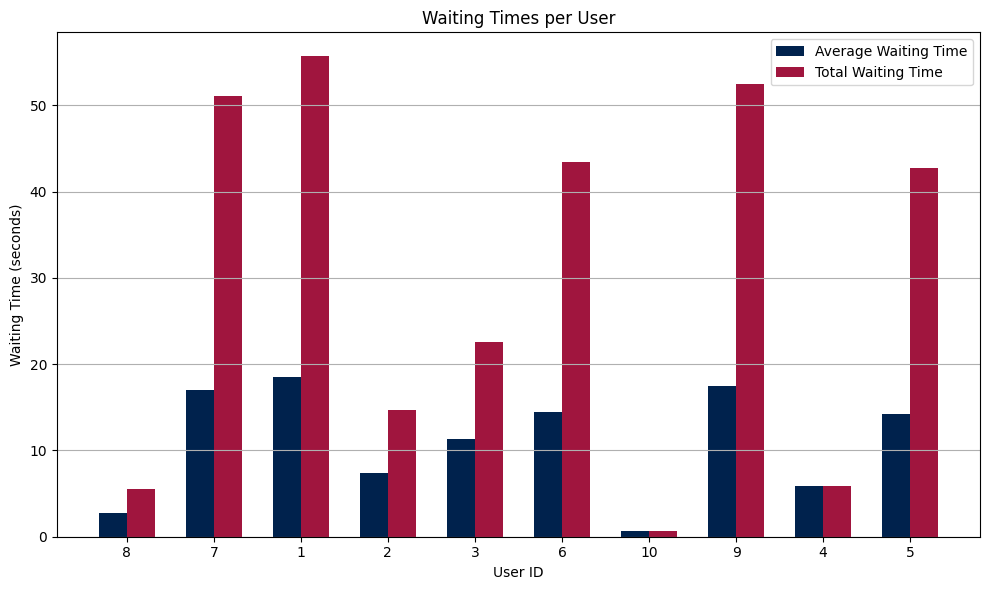

In [6]:
plot_waiting_times(task_records)

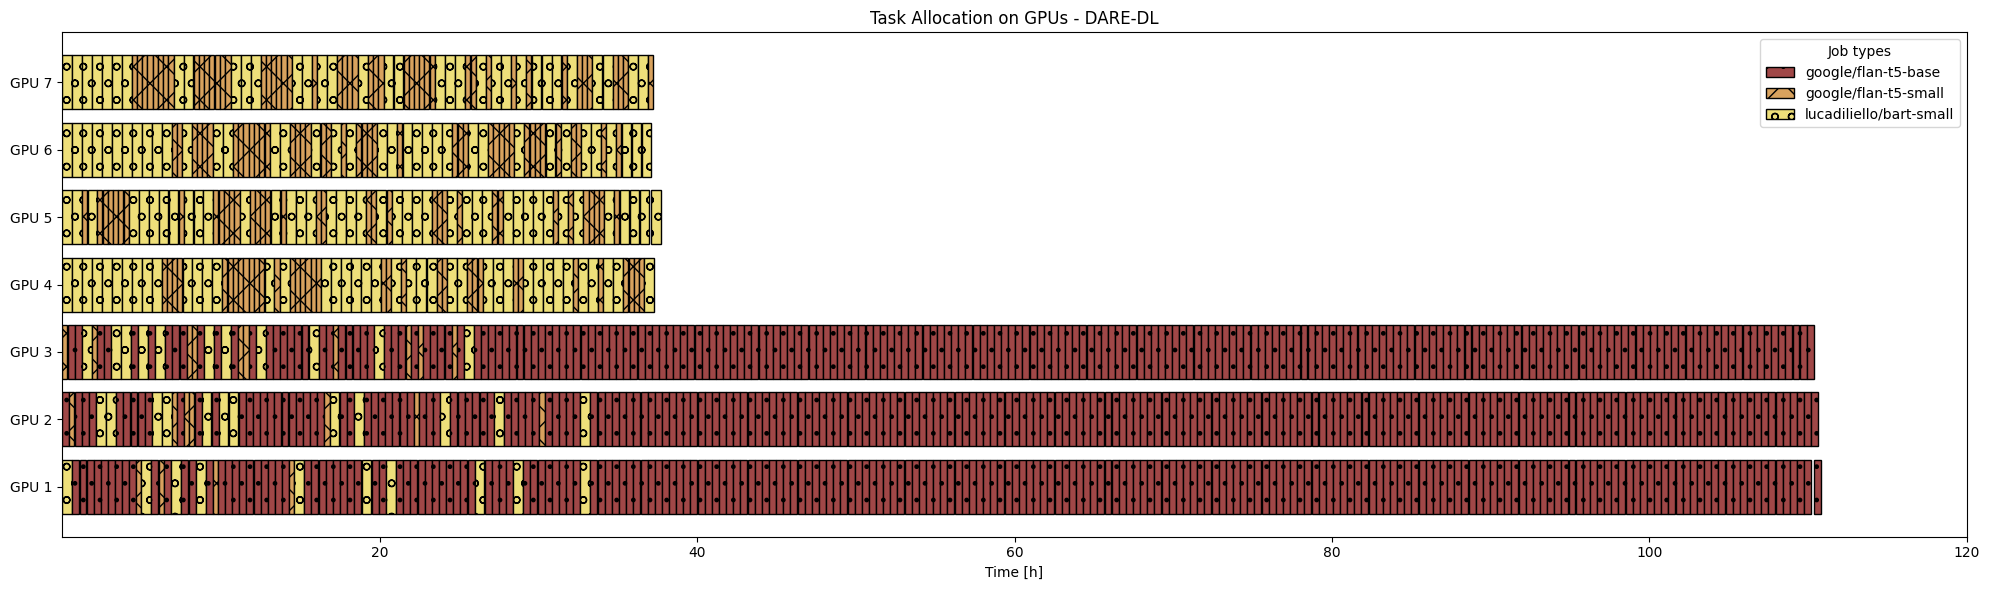

In [7]:
generate_gantt_gantt_executions(task_records, file_path.split("range_0.01_0.1_")[1])

<class 'numpy.ndarray'>
GPU 1 Tasks: 243, Total Training Time: 67.51616568273354, Unique Users: 10
GPU 2 Tasks: 243, Total Training Time: 67.51610521730495, Unique Users: 9
GPU 3 Tasks: 244, Total Training Time: 67.45547545775717, Unique Users: 10
GPU 4 Tasks: 76, Total Training Time: 22.832374517817758, Unique Users: 8
GPU 5 Tasks: 77, Total Training Time: 23.03237451781776, Unique Users: 8
GPU 6 Tasks: 79, Total Training Time: 22.68775261364042, Unique Users: 8
GPU 7 Tasks: 82, Total Training Time: 22.729286185507412, Unique Users: 8


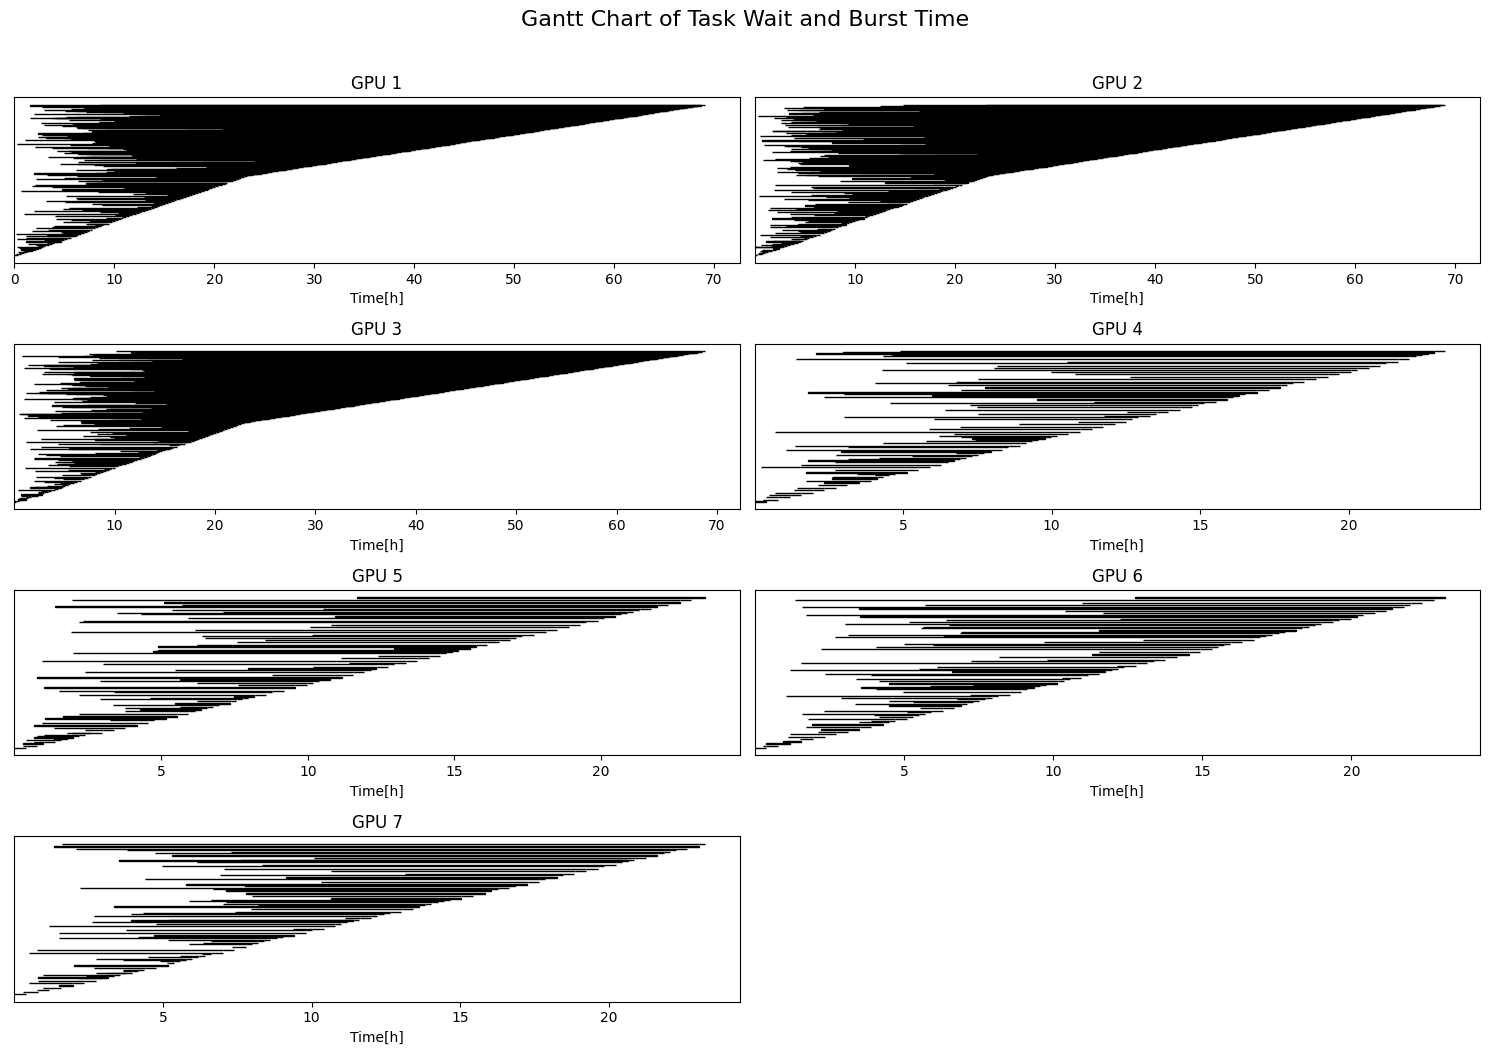

In [8]:
generate_gantt_arrival_ending_time(task_records)

### BENCHMARK

In [9]:
colors = [ "#3f88c5", "#AF1B3F", "#2a9d8f", "#2a9d8f", "#f4a261", "#264653"]
hatch = ['..', 'oo', 'OO', '-', '|', 'o']

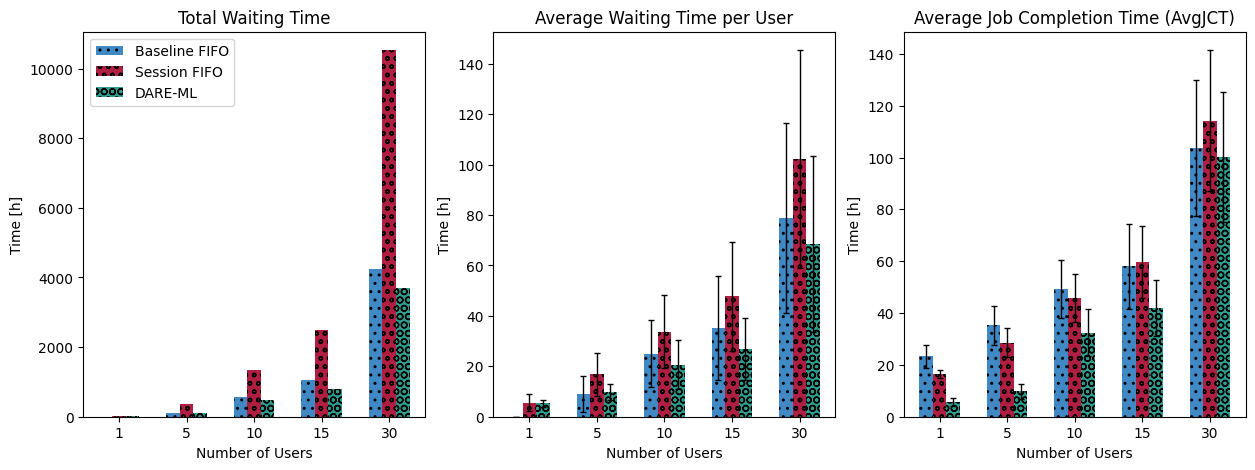

In [10]:
number_of_user = [1, 5, 10, 15, 30]

n_clusters = len(number_of_user)

# Bar width and positions
bar_width = 0.2
x = np.arange(n_clusters)

titles = ['Total Waiting Time', 'Average Waiting Time per User', 'Average Job Completion Time (AvgJCT)']
classes = ['Baseline FIFO', 'Session FIFO', 'DARE-ML']

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

totals_no_dare_no_session = []
totals_no_dare_yes_session = []
totals_yes_dare_no_session = []

average_per_user_no_dare_no_session = []
average_per_user_no_dare_yes_session = []
average_per_user_yes_dare_no_session = []

std_per_user_no_dare_no_session = []
std_per_user_no_dare_yes_session = []
std_per_user_yes_dare_no_session = []

avg_jct_no_dare_no_session = []
avg_jct_no_dare_yes_session = []
avg_jct_yes_dare_no_session = []

std_jct_no_dare_no_session = []
std_jct_no_dare_yes_session = []
std_jct_yes_dare_no_session = []

for n_users in number_of_user:
    # Load task records from the CSV file
    file_path_no_dare_no_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_False_v2.csv'  # Ensure this matches your saved file name
    file_path_no_dare_yes_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'  # Ensure this matches your saved file name
    file_path_yes_dare_no_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_True_session_False_v2.csv'  # Ensure this matches your saved file name

    task_records_no_dare_no_session = load_task_records(file_path_no_dare_no_session)
    task_records_no_dare_yes_session = load_task_records(file_path_no_dare_yes_session)
    task_records_yes_dare_no_session = load_task_records(file_path_yes_dare_no_session)

    results_no_dare_no_session = [parse_seconds_to_hours(t) / scaling_factor for t in calculate_total_waiting_time(task_records_no_dare_no_session)]
    results_no_dare_yes_session = [parse_seconds_to_hours(t) / scaling_factor for t in calculate_total_waiting_time(task_records_no_dare_yes_session)]
    results_yes_dare_no_session = [parse_seconds_to_hours(t) / scaling_factor for t in calculate_total_waiting_time(task_records_yes_dare_no_session)]

    totals_no_dare_no_session.append(results_no_dare_no_session[2])
    totals_no_dare_yes_session.append(results_no_dare_yes_session[2])
    totals_yes_dare_no_session.append(results_yes_dare_no_session[2])

    average_per_user_no_dare_no_session.append(np.array(results_no_dare_no_session[0]) )
    average_per_user_no_dare_yes_session.append(np.array(results_no_dare_yes_session[0]) )
    average_per_user_yes_dare_no_session.append(np.array(results_yes_dare_no_session[0]) )

    std_per_user_no_dare_no_session.append(np.array(results_no_dare_no_session[1]) )
    std_per_user_no_dare_yes_session.append(np.array(results_no_dare_yes_session[1]) )
    std_per_user_yes_dare_no_session.append(np.array(results_yes_dare_no_session[1]) )


    # Calculate AvgJCT and standard deviation for each configuration
    avg_jct_no_dare_no_session.append( parse_seconds_to_hours(calculate_avg_jct(task_records_no_dare_no_session)) / scaling_factor )
    avg_jct_no_dare_yes_session.append( parse_seconds_to_hours(calculate_avg_jct(task_records_no_dare_yes_session)) / scaling_factor )
    avg_jct_yes_dare_no_session.append( parse_seconds_to_hours(calculate_avg_jct(task_records_yes_dare_no_session)) / scaling_factor )

    std_jct_no_dare_no_session.append(calculate_jct_std(task_records_no_dare_no_session))
    std_jct_no_dare_yes_session.append(calculate_jct_std(task_records_no_dare_yes_session))
    std_jct_yes_dare_no_session.append(calculate_jct_std(task_records_yes_dare_no_session))


totals = [totals_no_dare_no_session, totals_no_dare_yes_session, totals_yes_dare_no_session]
average_per_user = [average_per_user_no_dare_no_session, average_per_user_no_dare_yes_session, average_per_user_yes_dare_no_session]
std_per_user = [std_per_user_no_dare_no_session, std_per_user_no_dare_yes_session, std_per_user_yes_dare_no_session]

# Organize data for plotting
avg_jct = [avg_jct_no_dare_no_session, avg_jct_no_dare_yes_session, avg_jct_yes_dare_no_session]
std_jct = [std_jct_no_dare_no_session, std_jct_no_dare_yes_session, std_jct_yes_dare_no_session]

# Create a bar chart for each subplot

for i, data in enumerate(totals):
    axes[0].bar(x + i * bar_width, data, bar_width,  label=classes[i], color=colors[i], hatch=hatch[i], alpha=.99)

for i, _ in enumerate(average_per_user):
    # axes[1].bar(x + i * bar_width, data, bar_width,  label=['no_dare_no_session', 'no_dare_yes_session', 'yes_dare_no_session'][i])
    avg = average_per_user[i]
    std = [s / 2  for s in std_per_user[i]]
    axes[1].bar(x + i * bar_width, avg, bar_width,  label=classes[i], yerr=std, error_kw=dict(lw=1, capsize=2, capthick=1), color=colors[i], hatch=hatch[i], alpha=.99)

for i, _ in enumerate(avg_jct):
    avg = avg_jct[i]
    std = [s / 2  for s in std_jct[i]] 
    axes[2].bar(x + i * bar_width, avg, bar_width,  label=classes[i], yerr=std, error_kw=dict(lw=1, capsize=2, capthick=1), color=colors[i], hatch=hatch[i], alpha=.99)

axes[0].set_title(titles[0])
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Time [h]')
axes[0].set_xticks(x + bar_width)
axes[0].set_xticklabels(number_of_user)
axes[0].legend()

axes[1].set_title(titles[1])
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Time [h]')
axes[1].set_xticks(x + bar_width)
axes[1].set_xticklabels(number_of_user)

axes[2].set_title(titles[2])
axes[2].set_xlabel('Number of Users')
axes[2].set_ylabel('Time [h]')
axes[2].set_xticks(x + bar_width)
axes[2].set_xticklabels(number_of_user)

# Show the plot
plt.savefig('time.pdf')
plt.show()
                                                

/home/matteo/Documents/postDoc/CTTC/Supercom/repo_git/plots/utils.py:301: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gpu_usage_base = gpu_df[df["Model_Name"] == "google/flan-t5-base"]["Training_Time"].sum()
/home/matteo/Documents/postDoc/CTTC/Supercom/repo_git/plots/utils.py:302: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gpu_usage_small = gpu_df[df["Model_Name"] == "google/flan-t5-small"]["Training_Time"].sum()
/home/matteo/Documents/postDoc/CTTC/Supercom/repo_git/plots/utils.py:303: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gpu_usage_bart = gpu_df[df["Model_Name"] == "lucadiliello/bart-small"]["Training_Time"].sum()
/home/matteo/Documents/postDoc/CTTC/Supercom/repo_git/plots/utils.py:301: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gpu_usage_base = gpu_df[df["Model_Name"] == "google/flan-t5-base"]["Training_Time"].sum()
/home/matteo/Documents/pos

4


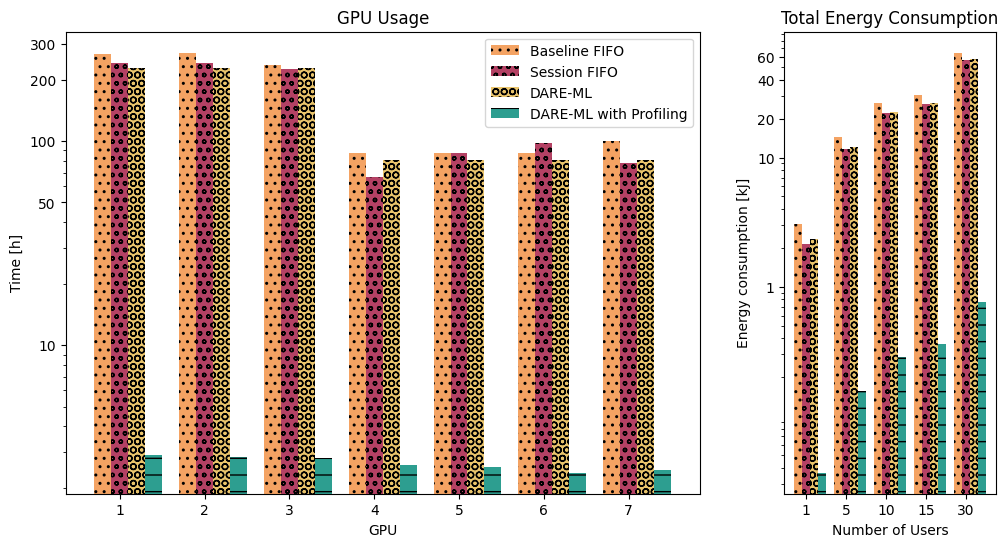

In [11]:
number_of_user = [1, 5, 10, 15, 30]

n_clusters = len(number_of_user)
n_gpus = 7

# Bar width and positions
bar_width = 0.2
x = np.arange(n_clusters)
x_gpu = np.arange(n_gpus)

titles = ['GPU Usage', 'Total Energy Consumption']
classes = ['Baseline FIFO', 'Session FIFO', 'DARE-ML', 'DARE-ML with Profiling']

colors = ['#F4A261', '#B33F62', '#E9C46A', '#2A9D8F']

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

gpus_usage_no_dare_no_session = []
gpus_usage_no_dare_yes_session = []
gpus_usage_yes_dare_no_session = []
gpus_usage_yes_dare_no_session_profiling = []

energy_total_no_dare_no_session = []
energy_total_no_dare_yes_session = []
energy_total_yes_dare_no_session = []
energy_total_yes_dare_no_session_profiling = []

for n_users in number_of_user:
    # Load task records from the CSV file
    file_path_no_dare_no_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_False_v2.csv'  # Ensure this matches your saved file name
    file_path_no_dare_yes_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'  # Ensure this matches your saved file name
    file_path_yes_dare_no_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_True_session_False_v2.csv'  # Ensure this matches your saved file name

    task_records_no_dare_no_session = load_task_records(file_path_no_dare_no_session)
    task_records_no_dare_yes_session = load_task_records(file_path_no_dare_yes_session)
    task_records_yes_dare_no_session = load_task_records(file_path_yes_dare_no_session)

    energy_total_no_dare_no_session_this_run = calc_tot_energy_from_df(task_records_no_dare_no_session)
    energy_total_no_dare_yes_session_this_run = calc_tot_energy_from_df(task_records_no_dare_yes_session)
    energy_total_yes_dare_no_session_this_run = calc_tot_energy_from_df(task_records_yes_dare_no_session)

    energy_total_no_dare_no_session_this_run_profiling = calc_tot_energy_from_df(task_records_no_dare_no_session, profiling=True)
    energy_total_no_dare_yes_session_this_run_profiling = calc_tot_energy_from_df(task_records_no_dare_yes_session, profiling=True)
    energy_total_yes_dare_no_session_this_run_profiling = calc_tot_energy_from_df(task_records_yes_dare_no_session, profiling=True)

    energy_total_no_dare_no_session.append(energy_total_no_dare_no_session_this_run[0] + energy_total_no_dare_no_session_this_run[1] + energy_total_no_dare_no_session_this_run[2])
    energy_total_no_dare_yes_session.append(energy_total_no_dare_yes_session_this_run[0] + energy_total_no_dare_yes_session_this_run[1] + energy_total_no_dare_yes_session_this_run[2])
    energy_total_yes_dare_no_session.append(energy_total_yes_dare_no_session_this_run[0] + energy_total_yes_dare_no_session_this_run[1] + energy_total_yes_dare_no_session_this_run[2])
    energy_total_yes_dare_no_session_profiling.append(energy_total_yes_dare_no_session_this_run_profiling[0] + energy_total_yes_dare_no_session_this_run_profiling[1] + energy_total_yes_dare_no_session_this_run_profiling[2])

n = 25
file_path_no_dare_no_session = f'../results/{n}_users_3_tasks/task_records_users_{n}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_False_v2.csv'  # Ensure this matches your saved file name
file_path_no_dare_yes_session = f'../results/{n}_users_3_tasks/task_records_users_{n}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'  # Ensure this matches your saved file name
file_path_yes_dare_no_session = f'../results/{n}_users_3_tasks/task_records_users_{n}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_True_session_False_v2.csv'  # Ensure this matches your saved file name
task_records_no_dare_no_session = load_task_records(file_path_no_dare_no_session)
task_records_no_dare_yes_session = load_task_records(file_path_no_dare_yes_session)
task_records_yes_dare_no_session = load_task_records(file_path_yes_dare_no_session)

gpu_usage_no_dare_no_session = [parse_seconds_to_hours(t) / scaling_factor for t in gpus_usage(task_records_no_dare_no_session)]
gpu_usage_no_dare_yes_session = [parse_seconds_to_hours(t) / scaling_factor for t in gpus_usage(task_records_no_dare_yes_session)]
gpu_usage_yes_dare_no_session = [parse_seconds_to_hours(t) / scaling_factor for t in gpus_usage(task_records_yes_dare_no_session)]
gpu_usage_yes_dare_no_session_profiling = [parse_seconds_to_hours(t) / scaling_factor for t in gpus_usage(task_records_yes_dare_no_session, profiling=True)]


gpus_usage_results = [gpu_usage_no_dare_no_session, gpu_usage_no_dare_yes_session, gpu_usage_yes_dare_no_session, gpu_usage_yes_dare_no_session_profiling]
energies = [energy_total_no_dare_no_session, energy_total_no_dare_yes_session, energy_total_yes_dare_no_session, energy_total_yes_dare_no_session_profiling]

print(len(gpus_usage_results))

# Create a bar chart for each subplot

for i, data in enumerate(gpus_usage_results):
    axes[0].bar(x_gpu + i * bar_width, data, bar_width,  label=classes[i], color=colors[i], hatch=hatch[i], alpha=.99)

for i, data in enumerate(energies):
    axes[1].bar(x + i * bar_width, data, bar_width,  label=classes[i], color=colors[i], hatch=hatch[i], alpha=.99)

axes[0].set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
axes[0].set_yticks([10, 50, 100, 200, 300])
axes[0].set_yticklabels([10, 50, 100, 200, 300])

axes[0].set_title(titles[0])
axes[0].set_xlabel('GPU')
axes[0].set_ylabel('Time [h]')
axes[0].set_xticks(x_gpu + bar_width)
axes[0].set_xticklabels(range(1,8))
axes[0].legend()

axes[1].set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
axes[1].set_yticks([1, 10, 20, 40, 60])
axes[1].set_yticklabels([1, 10, 20, 40, 60])

axes[1].set_title(titles[1])
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Energy consumption [kJ]')
axes[1].set_xticks(x + bar_width)
axes[1].set_xticklabels(number_of_user)

# Show the plot
plt.savefig('energy.pdf')                                                
plt.show()

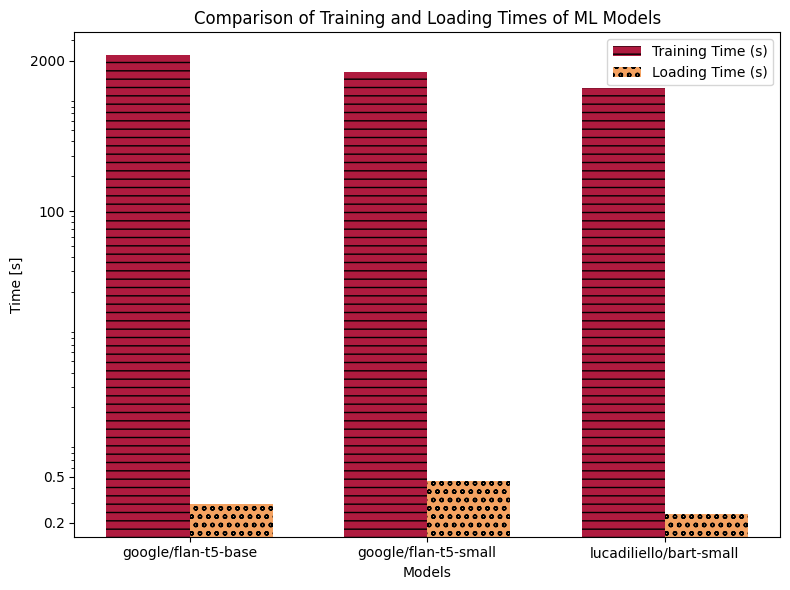

In [20]:
import numpy as np
hatch = ['--','oo']

# Data from the chart
models = ['google/flan-t5-base', 'google/flan-t5-small','lucadiliello/bart-small', ]
training_times = [2228.85, 1584.23, 1154.38]  # in seconds
loading_times = [0.29, 0.46, 0.24]  # in seconds

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Plotting the data
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, training_times, width, label='Training Time (s)', color='#AF1B3F', hatch=hatch[0])
bars2 = ax.bar(x + width/2, loading_times, width, label='Loading Time (s)', color='#F4A261',hatch=hatch[1])

# Adding labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Time [s]')
ax.set_title('Comparison of Training and Loading Times of ML Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
ax.set_yticks([0.2, 0.5, 100, 2000])
ax.set_yticklabels([0.2, 0.5, 100, 2000])

ax.legend()

# Adding values on top of bars
# for bars in [bars1, bars2]:
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate(f'{height:.2f}',
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

plt.tight_layout()
plt.savefig('ml_loading_training_times.pdf')     
plt.show()
